In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

### Target functions

In [3]:
def one_max(x):
    return x.sum()

def leading_ones(x):
    is_one = x == 1
    if all(is_one):
        return len(x)
    return np.argmin(is_one)

def jump(x, k=3):
    sum_ = x.sum()
    if len(x) == sum_:
        return len(x)
    return min(len(x) - k, sum_)

def bin_val(x):
    val = 0
    for bit in x:
        val = (val << 1) | bit
    return val

def royal_roads(x, k=5):
    # assert len(x) % k == 0, 'n must be divisible by k'
    return np.sum(np.sum(np.split(x, len(x) / k), axis=1) == k)

def is_max(x):
    # Return if x is the maximal possible value
    return x.sum() == len(x)

### Optimization functions ("evolutionary algorithms")

In [3]:
def rls(n, target_func, only_greater=False):
    x = np.random.randint(0, 2, n)
    steps = 0
    while not is_max(x):
        y = x.copy()
        idx = np.random.randint(len(y))
        y[idx] = not y[idx]
        if (target_func(y) > target_func(x) or
                (not only_greater and target_func(y) == target_func(x))):
            x = y
        steps += 1
    return steps

In [4]:
def oneOneEA(n, target_func, only_greater=False):
    x = np.random.randint(0, 2, n)
    steps = 0
    negate = np.vectorize(lambda x: not x)
    while not is_max(x):
        y = x.copy()
        probabilities = np.random.binomial(1, 1/n, n)
        y = probabilities * negate(y) + negate(probabilities) * y 
        if (target_func(y) > target_func(x) or
                (not only_greater and target_func(y) == target_func(x))):
            x = y
        steps += 1
    return steps

In [5]:
# TODO: random TIE BREAKING
def make_oneLambdaEA(populationSize):
    def oneLambdaEA(n, target_func, only_greater=False):
        x = np.random.randint(0, 2, n)
        steps = 0
        negate = np.vectorize(lambda x: not x)
        population = np.empty(populationSize)
        while not is_max(x):
            probabilities = np.random.binomial(1, 1/n, [populationSize, n])
            population = np.tile(x, (populationSize, 1))
            population = population * negate(probabilities) + negate(population) * probabilities
            popResults = np.apply_along_axis(target_func, 1, population)
            maxIndex = np.argmax(popResults) # TODO: TIE BREAKING
            if (popResults[maxIndex] > target_func(x) or
                    (not only_greater and popResults[maxIndex] == target_func(x))):
                x = population[maxIndex]
            steps += 1
        return steps
    return oneLambdaEA

### Evaluation

In [6]:
def evaluate(n, opt_func, problem, only_greater=False):
    problem_runtimes = np.empty(10)
    for i in range(10):
        problem_runtimes[i] = opt_func(n, problem, only_greater)
    return problem_runtimes

def evaluate_problem(ns, opt_func, problem, ax, only_greater=False):
    problems_runtimes = np.empty((len(ns), 10))
    for i, n in enumerate(ns):
        problems_runtimes[i] = evaluate(n, opt_func, problem, only_greater)
        print(".", end="")
    print("")
    ax.plot(problems_runtimes.mean(axis=1), label=problem.__name__)
    return problems_runtimes

def evaluate_algorithm(ns, opt_func, title, problems, ax, only_greater=False):
    # One optimizing algorithm which gets executed on all given problems
    algorithm_runtimes = np.empty((len(problems), len(ns), 10))
    for i, p in enumerate(problems):
        algorithm_runtimes[i] = evaluate_problem(ns, opt_func, p, ax, only_greater)
    # Plotting settings
    if len(ns) > 40:
        # Only show each 20th tick on the x axis
        plt.xticks(np.arange(0, len(ns), len(ns) // 20), ns[::len(ns) // 20])
    else:
        plt.xticks(np.arange(0, len(ns)), ns)
    ax.set_xlabel('n')
    ax.set_ylabel('Steps')
    ax.set_title(title)
    ax.set_yscale('log')
    ax.legend()
    return algorithm_runtimes

def evaluate_all(ns, algos, problems, only_greater=False):
    filename = "{} - {}".format(ns[-1], "g" if only_greater else "ge")
    # All optimizing algorithm are executed on all given problems
    fig, axes = plt.subplots(len(algos), 1, figsize=(16, 8 * len(algos)))
    # Hotfix to make "axes.flat" work for only one algorithm
    if len(algos) == 1:
        axes = np.array([axes])
    for algo, ax in zip(algos, axes.flat):
        evaluate_algorithm(ns, algo, '{} - {}'.format(filename, algo.__name__),
                           problems, ax, only_greater)
    # Contains n and the only_greater flag
    fig.savefig("{}.pdf".format(filename))

..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
..
CPU times: user 1min 41s, sys: 526 ms, total: 1min 42s
Wall time: 1min 42s


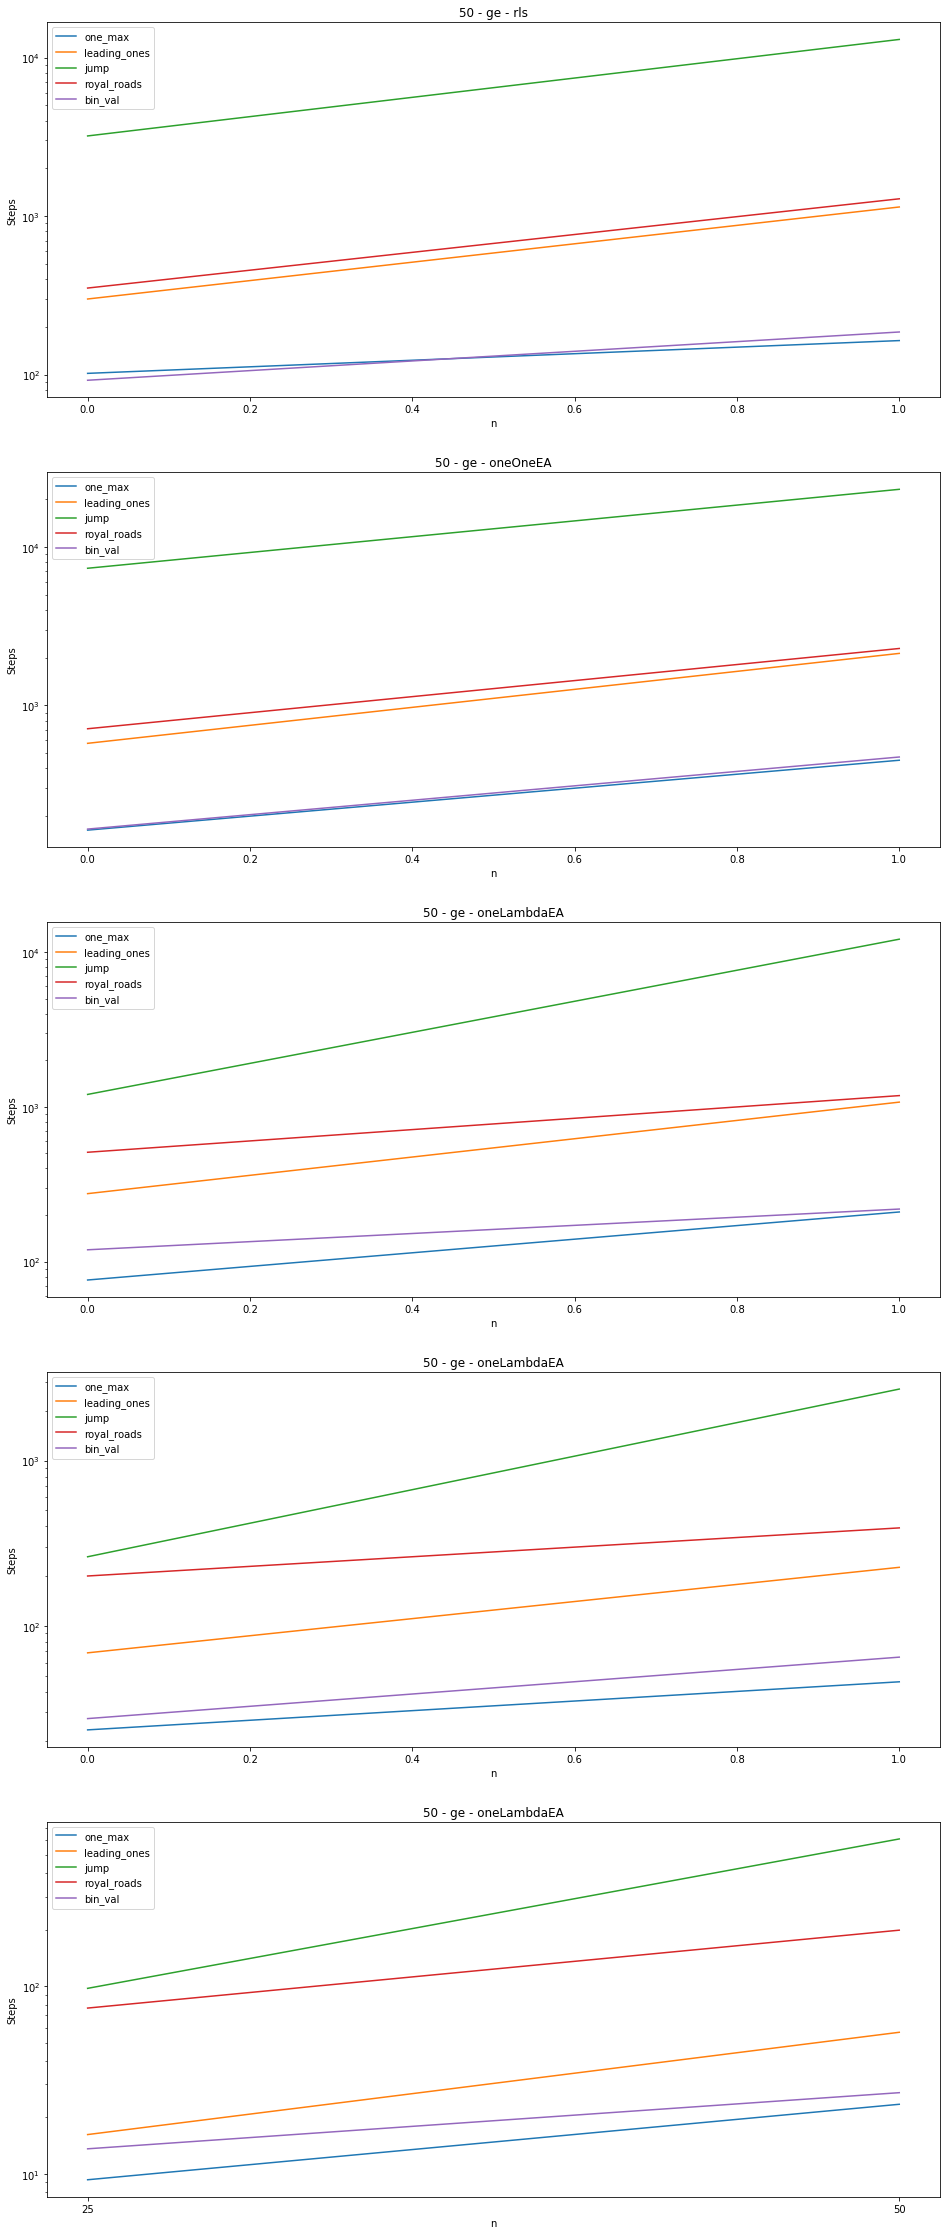

In [16]:
algorithms = (rls, oneOneEA, make_oneLambdaEA(2), make_oneLambdaEA(10), make_oneLambdaEA(50))
problems = (one_max, leading_ones, jump, royal_roads, bin_val)
%time evaluate_all(np.arange(25, 201, 25), algorithms, problems, only_greater=False)

In [ ]:
%time evaluate_all(np.arange(25, 201, 25), algorithms, problems, only_greater=True)

........
........


# Analysis

Manually plot result:

In [24]:
import project1.results as results

def plot_results(*args):
    ns = np.array([25, 50, 75, 100, 125, 150, 175])
    fig, axes = plt.subplots(len(args), 2, figsize=(16, 6 * len(args)))
    if len(args) == 1:
        axes = [axes]
    for title, labels, all_runtimes, row_axes in zip(*zip(*args), axes):
        for i, ax in enumerate(row_axes):
            max_val = 0
            for label, problems_runtimes in zip(labels, all_runtimes):
                means = problems_runtimes.mean(axis=1)
                ax.plot(means, label=label)
                if label != "jump":
                    max_val = max(max_val, np.max(means))
            if len(ns) > 40:
                # Only show each 20th tick on the x axis
                plt.xticks(np.arange(0, len(ns), len(ns) // 20), ns[::len(ns) // 20])
            else:
                plt.xticks(np.arange(0, len(ns)), ns)
            ax.set_xlabel('n')
            ax.set_ylabel('Steps')
            ax.set_title('{}{}'.format(title, '' if i == 1 else ' [log scale]'))
            if i == 0:
                ax.set_yscale('log')
            else:
                ax.set_ylim([0, max_val])
            ax.legend(loc='upper left')

#### 1.) Random Local Search

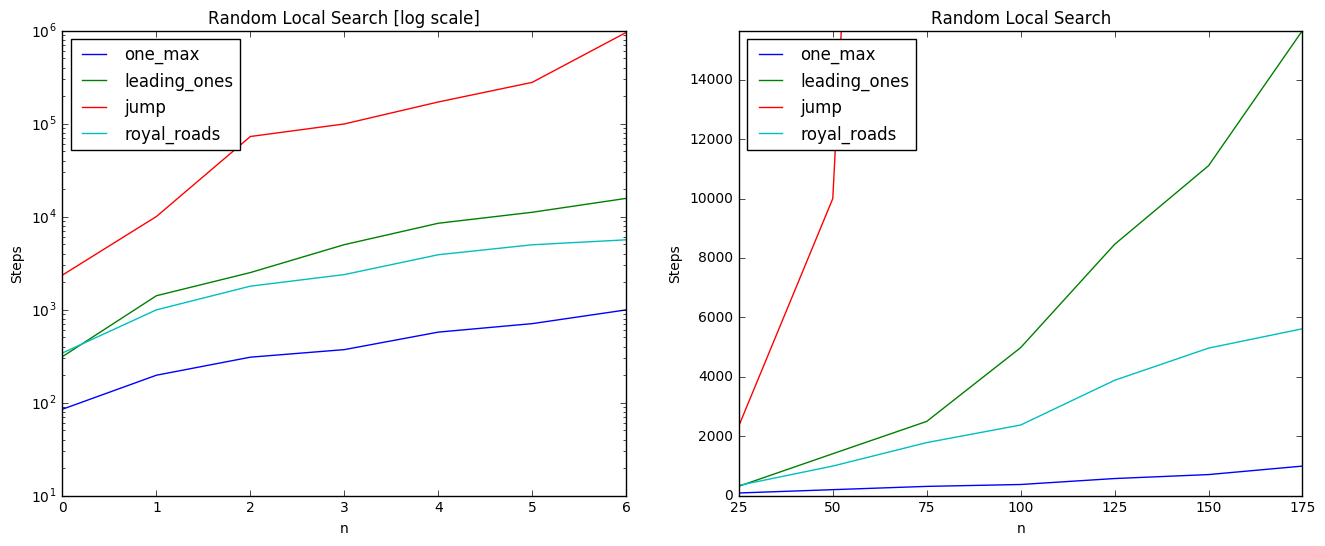

In [25]:
plot_results(results.get_rls())

The algorithm takes much more time for "jump" than for each other problem.

In comparison to the other algorithms it always needs longer for "leading_ones" than "royal_roads".

"one_max" is always executed as the fastest one. This might be because there is only one local (and also global) maximum and the steps are smaller.
In contrast to that "royal_roads" might return the same value for much more combinations because the bits are splitted into groups. "jump" is the hardest problem because the space around the global maximum always returns the same value.

Approximated complexity (in O-Notation):
- one_max: $\mathcal{O}(n)$
- leading_ones: $\mathcal{O}(n^c)$
- jump: $\mathcal{O}(c^n)$
- royal_roads: $\mathcal{O}(n)$

#### 2.) Evolutionary Algorithm - (1+1)-EA

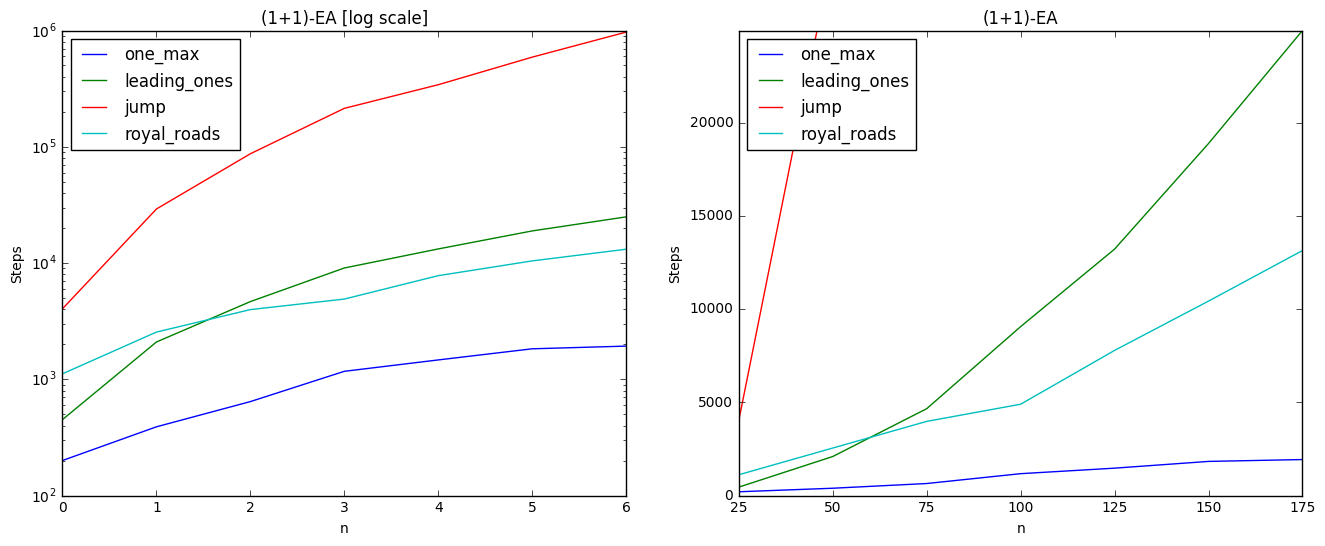

In [26]:
plot_results(results.get_one_one())

This algorithm takes just as long as RLS for all problems.

Approximated complexity (in O-Notation):
- one_max: $\mathcal{O}(n)$
- leading_ones: $\mathcal{O}(n^c)$
- jump: $\mathcal{O}(n^c)$
- royal_roads: $\mathcal{O}(n^c)$

#### 3.) Evolutionary Algorithm - (1+$\lambda$)-EA

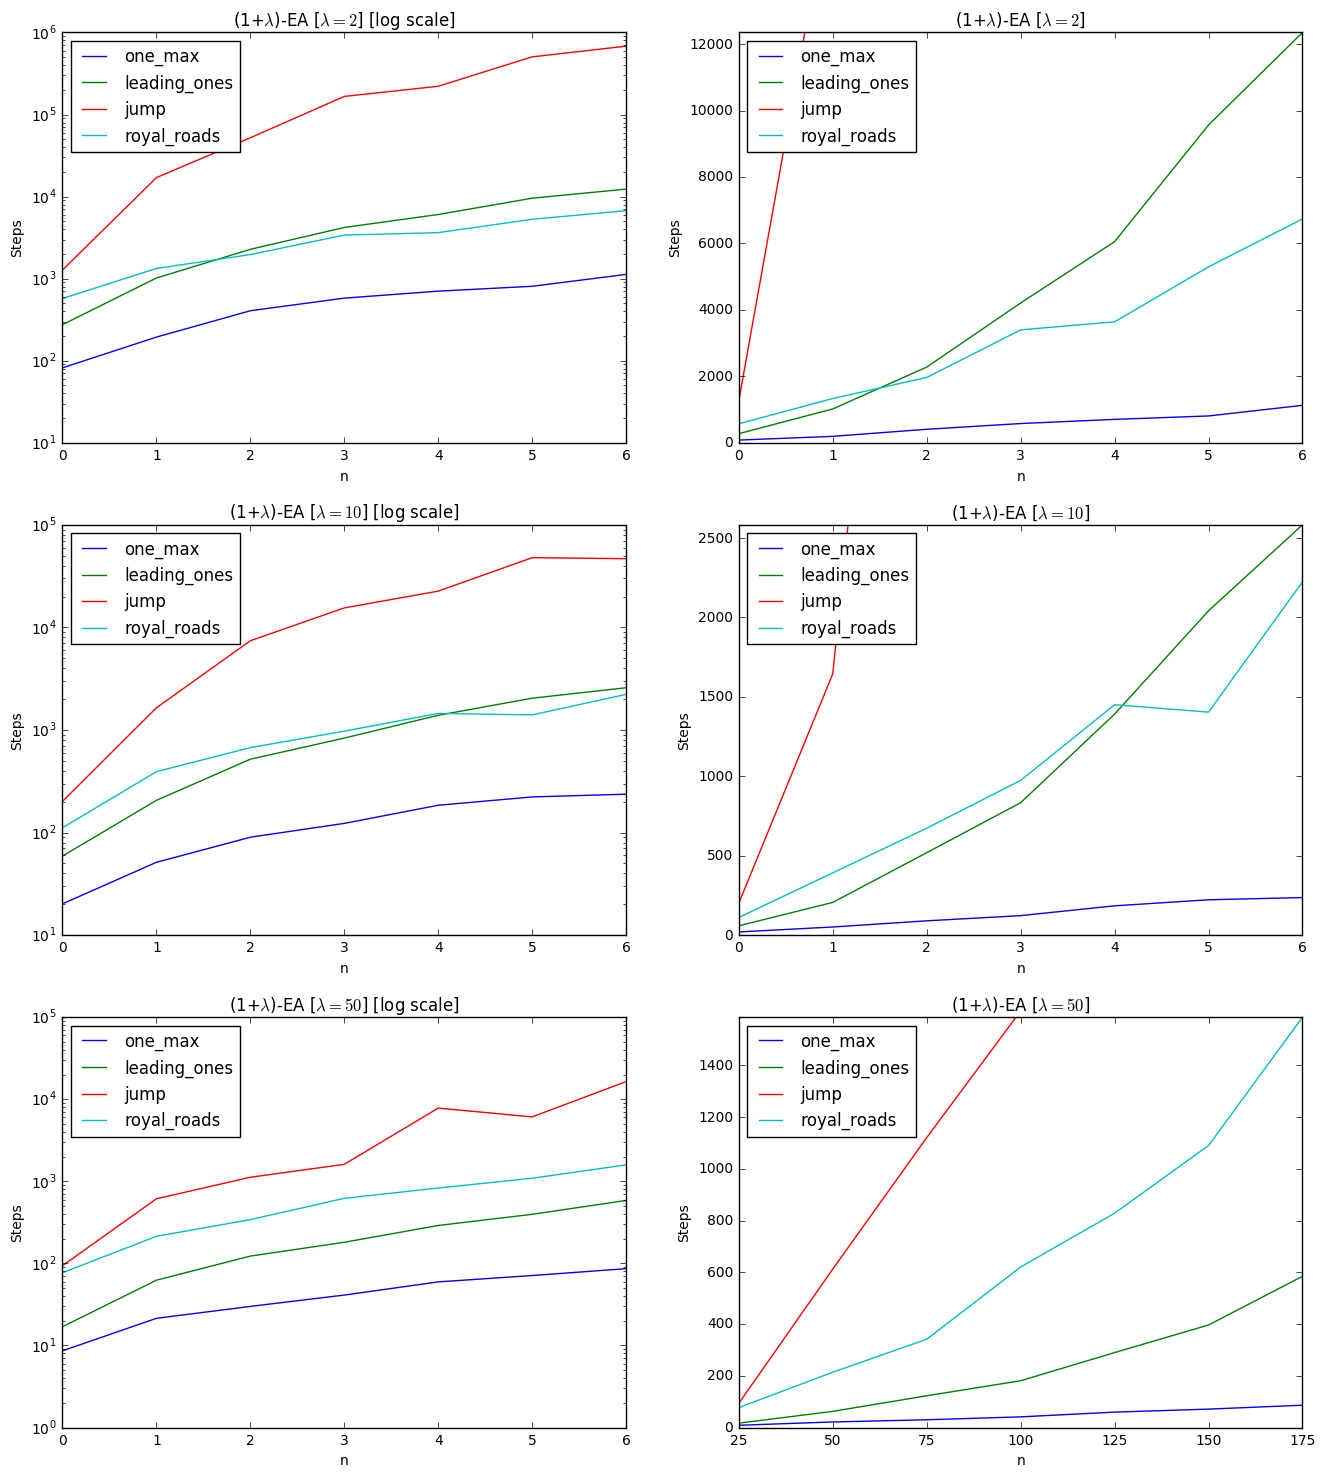

In [27]:
plot_results(results.get_one_lambda_2(), results.get_one_lambda_10(), results.get_one_lambda_50())

Again the algorithm takes much more time for "jump" than for each other problem - independent of $\lambda$.

Interestingly the costs sometimes decrease between two values $n_i$ and $n_{i+1}$ This might be due to the randomness of finding the solution.

With an increasing $\lambda$ the algorithm becomes much faster (by factor ~10) for all problems. Furthermore the costs of "leading_ones" shrink faster than the costs of "royal_roads" with an increasing $\lambda$.

In comparison to the other algorithms this algorithm with $\lambda=50$ is the only one with a relative good performance for "jump".

Approximated complexity (in O-Notation):
- one_max: $\mathcal{O}(n)$
- leading_ones: $\mathcal{O}(n^c)$
- jump: $\mathcal{O}(n^c)$
- royal_roads: $\mathcal{O}(n^c)$

### Results with $greater\_only=True$

In [ ]:
import imp
imp.reload(results)

plot_results(
    results.get_rls_go(), results.get_one_one_go(), results.get_one_lambda_2_go(),
    results.get_one_lambda_10_go(), results.get_one_lambda_50_go())